In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import scipy.stats as stats
from scipy.signal import savgol_filter

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_parquet("data/posts_reactions_df_topic_info.parquet")
# df["ds"] = pd.to_datetime(df["ds"])
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values(by="ds")
df["ds"] = df["ds"].dt.tz_localize(None)
df["date"] = df["date"].dt.tz_localize(None)

In [4]:
df = df.sort_values(by='date', ascending=True)
df['pct_change_reactions_score'] = df['reactions_score'].pct_change()

# Define reasonable caps based on your data distribution
pct_change_reactions_score_upper_cap = np.percentile(df['pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 99)
pct_change_reactions_score_lower_cap = np.percentile(df['pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 1)

# Apply caps to infinities
df['pct_change_reactions_score'] = df['pct_change_reactions_score'].replace(np.inf, pct_change_reactions_score_upper_cap)
df['pct_change_reactions_score'] = df['pct_change_reactions_score'].replace(-np.inf, pct_change_reactions_score_lower_cap)

<Axes: >

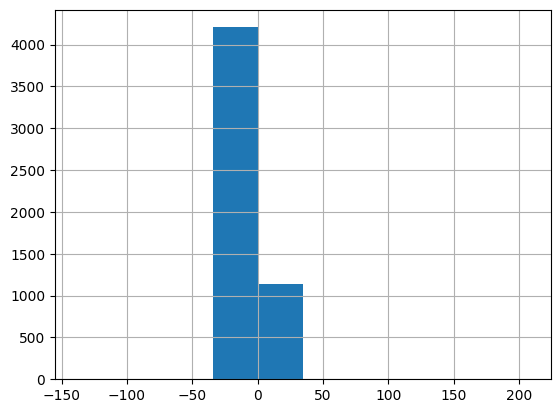

In [5]:
df.pct_change_reactions_score.hist()

In [6]:
df['log_pct_change_reactions_score'] = np.sign(df['pct_change_reactions_score']) * np.log1p(np.abs(df['pct_change_reactions_score']))
# df['log_pct_change_reactions_score'] = np.log(df['pct_change_reactions_score']) 

# Define reasonable caps based on your data distribution
log_pct_change_reactions_score_upper_cap = np.percentile(df['log_pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 99)
log_pct_change_reactions_score_lower_cap = np.percentile(df['log_pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 1)

# Apply caps to infinities
df['log_pct_change_reactions_score'] = df['log_pct_change_reactions_score'].replace(np.inf, pct_change_reactions_score_upper_cap)
df['log_pct_change_reactions_score'] = df['log_pct_change_reactions_score'].replace(-np.inf, pct_change_reactions_score_lower_cap)

In [7]:
print(sum(df.log_pct_change_reactions_score.isna()))
print(sum(df.pct_change_reactions_score.isna()))
print(sum(df.reactions_score.isna()))

1
1
0


In [8]:
# df['pct_change_reactions_score'] = df['pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan)
# df.pct_change_reactions_score = df.pct_change_reactions_score.fillna(0.0)

In [9]:
# 1. Calculate the three moving averages
df['init_ma7'] = df['log_pct_change_reactions_score'].rolling(window=7, min_periods=1).mean()
df['ma7'] = df['init_ma7'].rolling(window=7, min_periods=1).mean()

df['init_ma15'] = df['log_pct_change_reactions_score'].rolling(window=15, min_periods=1).mean()
df['ma15'] = df['init_ma15'].rolling(window=15, min_periods=1).mean()

df['init_ma21'] = df['log_pct_change_reactions_score'].rolling(window=21, min_periods=1).mean()
df['ma21'] = df['init_ma21'].rolling(window=21, min_periods=1).mean()

In [10]:
def fit_prophet_and_get_changepoints(data, column='y', n_changepoints=25, 
                                    changepoint_prior_scale=0.05, changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True):
    # Prepare dataframe
    prophet_df = data[['ds', column]].rename(columns={column: 'y'})
    
    # Fit model
    model = Prophet(n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    changepoint_range=changepoint_range,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=weekly_seasonality
                   )
    model.fit(prophet_df)
    
    # Get forecast and extract changepoint information
    future = model.make_future_dataframe(periods=0)  # No forecasting needed
    forecast = model.predict(future)
    
    # Extract changepoints with their magnitudes
    cp_dates = model.changepoints
    cp_effects = model.params['delta'].flatten()
    cp_magnitudes = forecast.loc[forecast['ds'].isin(cp_dates), 'trend'].values
    
    # Create dataframe of changepoints
    changepoints = pd.DataFrame({
        'date': cp_dates,
        'magnitude': np.abs(cp_magnitudes),
        'cp_value': cp_effects
    }).sort_values('cp_value', ascending=False)
    
    return model, changepoints

In [11]:
# Fit models to each smoothed series
_, cp_raw = fit_prophet_and_get_changepoints(df, 'log_pct_change_reactions_score')
_, cp_ma7 = fit_prophet_and_get_changepoints(df, 'ma7')
_, cp_ma15 = fit_prophet_and_get_changepoints(df, 'ma15')
_, cp_ma21 = fit_prophet_and_get_changepoints(df, 'ma21')


14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:59 - cmdstanpy - INFO - Chain [1] done processing
14:26:59 - cmdstanpy - INFO - Chain [1] start processing
14:26:59 - cmdstanpy - INFO - Chain [1] done processing
14:27:00 - cmdstanpy - INFO - Chain [1] start processing
14:27:00 - cmdstanpy - INFO - Chain [1] done processing
14:27:01 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
def jaccard_similarity(cp1, cp2, window_days=3, top_n=30):
    """Calculate Jaccard similarity between two sets of changepoints"""
    cp1_top = cp1['date']
    cp2_top = cp2['date']
    
    # Count matched changepoints
    intersection = 0
    for date1 in cp1_top:
        for date2 in cp2_top:
            if abs((date1 - date2).days) <= window_days:
                intersection += 1
                # print(date1, date2)
                break
    
    # Calculate Jaccard similarity
    union = len(cp1_top) + len(cp2_top) - intersection
    return intersection / union if union > 0 else 0

In [13]:
similarity_matrix = pd.DataFrame(
    index=['Raw', 'MA7', 'MA15', 'MA21'],
    columns=['Raw', 'MA7', 'MA15', 'MA21'],
    data=0.0
)

In [52]:
# Fill similarity matrix
changepoint_sets = {'Raw': cp_raw, 'MA7': cp_ma7, 'MA15': cp_ma15, 'MA21': cp_ma21}
for i in similarity_matrix.index:
    for j in similarity_matrix.columns:
        if i == j:
            similarity_matrix.loc[i, j] = 1.0
        else:
            similarity_matrix.loc[i, j] = jaccard_similarity(
                changepoint_sets[i], changepoint_sets[j])

In [53]:
similarity_matrix

,Raw,MA7,MA15,MA21
Raw,1.0,1.0,1.0,1.0
MA7,1.0,1.0,1.0,1.0
MA15,1.0,1.0,1.0,1.0
MA21,1.0,1.0,1.0,1.0


In [16]:
print("Jaccard Similarity Matrix of Changepoint Sets:")
print(similarity_matrix)


Jaccard Similarity Matrix of Changepoint Sets:
      Raw  MA7  MA15  MA21
Raw   1.0  1.0   1.0   1.0
MA7   1.0  1.0   1.0   1.0
MA15  1.0  1.0   1.0   1.0
MA21  1.0  1.0   1.0   1.0


In [17]:
# Calculate average similarity for each method
avg_similarities = similarity_matrix.mean(axis=1)
print("\nAverage similarity score for each method (higher means more consistent with others):")
print(avg_similarities)


Average similarity score for each method (higher means more consistent with others):
Raw     1.0
MA7     1.0
MA15    1.0
MA21    1.0
dtype: float64


In [56]:
changepoint_sets_df = pd.concat(changepoint_sets).reset_index()

In [58]:
# Get top 3 changepoints from each method
common_changepoints = {}
for method, cp_set in changepoint_sets.items():
    for _, row in cp_set.iterrows():
        date = row['date']
        magnitude = row['cp_value']
        
        # Check if this date is already in common_changepoints (within window)
        added = False
        for existing_date in list(common_changepoints.keys()):
            if abs((date - existing_date).days) <= event_window:
                common_changepoints[existing_date].append((method, magnitude))
                added = True
                break
        
        if not added:
            common_changepoints[date] = [(method, magnitude)]

In [61]:
# Only keep dates detected by at least 2 methods
consistent_changepoints = {date: methods for date, methods in common_changepoints.items() 
                         if len(methods) >= 2}

print(f"\nFound {len(consistent_changepoints)} consistent changepoints across methods:")


Found 25 consistent changepoints across methods:


In [64]:
consistent_changepoints_df = pd.DataFrame(consistent_changepoints.items())
consistent_changepoints_df.columns = ["date", "methods"]
consistent_changepoints_df["method"] = "reactions_score"
consistent_changepoints_df.to_excel("log_transformed_pct_change_reactions_score_consistent_changepoints.xlsx", index=False)

In [63]:
consistent_changepoints_df

,date,methods,method
0,2022-07-04 10:51:31,"[(Raw, 0.00561893), (MA7, 0.0375529), (MA15, 0...",reactions_score
1,2022-08-25 06:17:38,"[(Raw, 0.00547577), (MA7, 0.0329134), (MA15, 0...",reactions_score
2,2022-10-16 04:46:36,"[(Raw, 0.00515487), (MA7, 0.0402634), (MA15, 0...",reactions_score
3,2022-05-21 21:10:11,"[(Raw, 0.00428256), (MA7, 0.0232446), (MA15, 0...",reactions_score
4,2022-12-01 16:53:28,"[(Raw, 0.00346843), (MA7, 0.0358117), (MA15, 0...",reactions_score
5,2022-03-30 15:27:21,"[(Raw, 0.00255653), (MA7, 7.43634e-07), (MA15,...",reactions_score
6,2023-02-04 20:11:00,"[(Raw, 0.00176569), (MA7, 0.0240006), (MA15, 6...",reactions_score
7,2023-03-30 02:43:01,"[(Raw, 1.87203e-05), (MA7, 0.00595796), (MA15,...",reactions_score
8,2023-05-21 11:31:46,"[(Raw, 2.22999e-06), (MA7, 4.66129e-06), (MA15...",reactions_score
9,2023-06-11 08:06:25,"[(Raw, 1.56433e-06), (MA7, 2.87451e-08), (MA15...",reactions_score


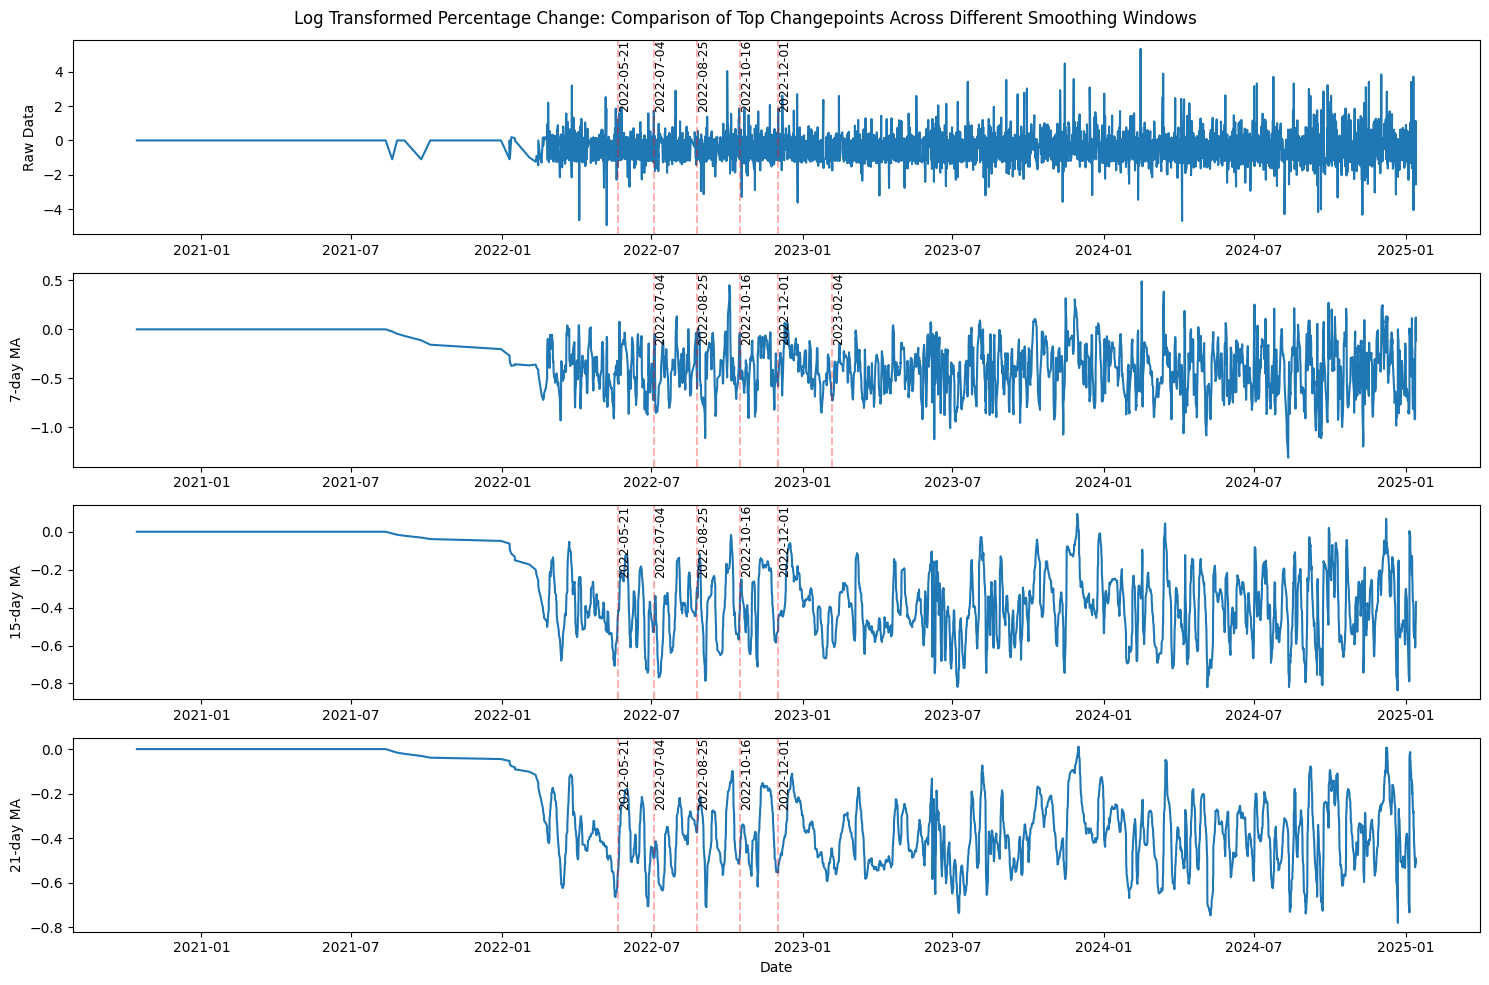

In [18]:
plt.figure(figsize=(15, 10))

# Create subplots for each time series
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2)
ax3 = plt.subplot(4, 1, 3)
ax4 = plt.subplot(4, 1, 4, sharex=ax1)  # Share x-axis with first plot

# Plot each time series with vertical lines for changepoints
for ax, label, data_col, cp_data in [
    (ax1, 'Raw Data', 'log_pct_change_reactions_score', cp_raw),
    (ax2, '7-day MA', 'ma7', cp_ma7),
    (ax3, '15-day MA', 'ma15', cp_ma15),
    (ax4, '21-day MA', 'ma21', cp_ma21)
]:
    # Plot the time series
    ax.plot(df['ds'], df[data_col])
    ax.set_ylabel(label)
    
    # Add vertical lines for top 5 changepoints
    for i, row in cp_data.head(5).iterrows():
        ax.axvline(x=row['date'], color='r', linestyle='--', alpha=0.3)
        ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                rotation=90, verticalalignment='top', fontsize=9)

ax4.set_xlabel('Date')
plt.suptitle('Log Transformed Percentage Change: Comparison of Top Changepoints Across Different Smoothing Windows')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [19]:
changepoint_sets_df = pd.concat(changepoint_sets).reset_index()

In [20]:
changepoint_sets_df.date

0    2022-07-04 10:51:31
1    2022-08-25 06:17:38
2    2022-10-16 04:46:36
3    2022-05-21 21:10:11
4    2022-12-01 16:53:28
             ...        
95   2024-02-08 10:21:08
96   2024-05-01 11:23:06
97   2024-03-23 11:48:15
98   2024-06-09 15:10:28
99   2024-07-14 07:34:58
Name: date, Length: 100, dtype: datetime64[ns]

In [21]:
changepoint_sets_df[changepoint_sets_df.date == '2022-08-25 06:17:38']

,level_0,level_1,date,magnitude,cp_value
1,Raw,815,2022-08-25 06:17:38,0.400737,0.005476
28,MA7,815,2022-08-25 06:17:38,0.400865,0.032913
53,MA15,815,2022-08-25 06:17:38,0.397543,0.137145
78,MA21,815,2022-08-25 06:17:38,0.397797,0.190515


In [51]:
changepoint_sets_df

,level_0,level_1,date,magnitude,cp_value
0,Raw,612,2022-07-04 10:51:31,0.396906,0.005619
1,Raw,815,2022-08-25 06:17:38,0.400737,0.005476
2,Raw,1019,2022-10-16 04:46:36,0.403599,0.005155
3,Raw,408,2022-05-21 21:10:11,0.392842,0.004283
4,Raw,1223,2022-12-01 16:53:28,0.405338,0.003468
...,...,...,...,...,...
95,MA21,3261,2024-02-08 10:21:08,0.381806,-0.009324
96,MA21,3669,2024-05-01 11:23:06,0.380171,-0.097346
97,MA21,3465,2024-03-23 11:48:15,0.379728,-0.116201
98,MA21,3873,2024-06-09 15:10:28,0.382535,-0.125072


In [22]:
changepoint_sets_df.groupby('level_0').cp_value.mean()

level_0
MA15    0.020698
MA21    0.027872
MA7     0.004100
Raw     0.001134
Name: cp_value, dtype: float64

In [36]:
print(df[df.date == '2023-07-02 17:21:41'].text.iloc[0])

"Собака почала їсти"

Два дні тому дівчата, які чергують на вокзалі і допомагають переселенцям,  зателефонувати мені і попросили корм та намордник для собаки, німецької вівчарки з Херсона. 

Я поїхала в Центр адопції та передала всі необхідні речі, додала щось для собаки.

Наступного дня від колеги з ГО "Десяте Квітня", психолога Таяни Товстиги, я почула історію хлопця з вівчаркою.

Хлопець прийшов в Одесу пішки, бо евакуаційні автобуси відмовили йому через те, що у собаки немає намордника. 

Так, він не купив і не попросив, бо просто не мав на це моральних сил. Його дружину та п’ятирічну доньку вбило ракетою, яка прилетіла в будинок.

Але з будинку він не їхав, навіть через руйнацію, він поїхав лише тоді, коли піднялася вода, і громадяни російської федерації остаточно зруйнували місце, де він колись був щасливий. 

Не сівши в автобус, він просто пішов.... Він йшов три дні, маючи лише 300 грн на корм для собаки і воду.

Зараз йому знайшли квартиру, почали відновлювати документи, повніс

In [23]:
df[df.log_pct_change_reactions_score.apply(lambda x: abs(x) > 5)].date

481   2024-02-14 07:54:45
Name: date, dtype: datetime64[ns]

In [24]:
changepoint_dates_set = set(changepoint_sets_df.date.unique())

In [25]:
changepoint_dates_set

{Timestamp('2022-03-30 15:27:21'),
 Timestamp('2022-05-21 21:10:11'),
 Timestamp('2022-07-04 10:51:31'),
 Timestamp('2022-08-25 06:17:38'),
 Timestamp('2022-10-16 04:46:36'),
 Timestamp('2022-12-01 16:53:28'),
 Timestamp('2023-02-04 20:11:00'),
 Timestamp('2023-03-30 02:43:01'),
 Timestamp('2023-05-21 11:31:46'),
 Timestamp('2023-06-11 08:06:25'),
 Timestamp('2023-07-02 17:21:41'),
 Timestamp('2023-08-09 15:19:24'),
 Timestamp('2023-09-09 17:03:16'),
 Timestamp('2023-10-29 02:31:27'),
 Timestamp('2023-12-22 15:16:30'),
 Timestamp('2024-02-08 10:21:08'),
 Timestamp('2024-03-23 11:48:15'),
 Timestamp('2024-05-01 11:23:06'),
 Timestamp('2024-06-09 15:10:28'),
 Timestamp('2024-07-14 07:34:58'),
 Timestamp('2024-08-18 17:13:12'),
 Timestamp('2024-09-15 15:58:11'),
 Timestamp('2024-10-14 04:25:12'),
 Timestamp('2024-11-14 21:14:24'),
 Timestamp('2024-12-15 18:38:22')}

In [26]:
len(df[df.ma21.apply(lambda x: abs(x) > 1)].date.unique())

0

In [36]:
ma21_above_5 = set(df[df.ma21.apply(lambda x: abs(x) > 1)].date.unique())

In [37]:
ma21_above_5.intersection(changepoint_dates_set)

set()

In [121]:
ma15_above_5 = set(df[df.ma15.apply(lambda x: abs(x) > 1)].date.unique())
ma15_above_5.intersection(changepoint_dates_set)

{Timestamp('2022-05-21 15:06:09'),
 Timestamp('2022-11-30 04:17:37'),
 Timestamp('2023-03-29 12:09:00'),
 Timestamp('2023-12-22 15:06:36'),
 Timestamp('2024-03-23 11:48:15'),
 Timestamp('2024-06-09 15:10:28'),
 Timestamp('2024-10-14 04:25:12')}

In [125]:
df.ma7

4451    0.000000
4452    0.000000
4453    0.000000
1252    0.000000
1253    0.000000
          ...   
5365    0.160245
5366    0.222420
4268   -0.059713
4269   -0.359700
4270   -0.624677
Name: ma7, Length: 5367, dtype: float64

In [129]:
ma7_above_5 = set(df[df.ma7.apply(lambda x: abs(x) > 1)].date.unique())
ma7_above_5.intersection(changepoint_dates_set)

{Timestamp('2022-03-30 10:25:28'),
 Timestamp('2022-05-21 15:06:09'),
 Timestamp('2022-08-25 06:17:38'),
 Timestamp('2023-02-04 05:44:59'),
 Timestamp('2023-08-09 15:19:24'),
 Timestamp('2024-02-08 10:21:08'),
 Timestamp('2024-08-18 15:52:58'),
 Timestamp('2024-10-14 04:25:12')}

In [165]:
set(df[df.ma21.apply(lambda x: abs(x) >= 10)].date.unique())

set()

In [38]:
changepoints_sets = {
    'Prophet': changepoint_dates_set,
    '7MA': set(df[df.ma7.apply(lambda x: abs(x) >= 10)].date.unique()),
    '15MA': set(df[df.ma15.apply(lambda x: abs(x) >= 10)].date.unique()),
    '21MA': set(df[df.ma21.apply(lambda x: abs(x) >= 10)].date.unique()),
}

In [159]:
event_window = 5
common_changepoints = {}
for method, cp_set in changepoints_sets.items():
    for date in cp_set:
        # Check if this date is already in common_changepoints (within window)
        added = False
        for existing_date in list(common_changepoints.keys()):
            if abs((date - existing_date).days) <= event_window:
                common_changepoints[existing_date].append((method))
                added = True
                break
        
        if not added:
            common_changepoints[date] = [(method)]

In [154]:
common_7ma_changepoints

{Timestamp('2023-05-21 11:31:46'): ['Prophet'],
 Timestamp('2022-08-25 06:17:38'): ['Prophet'],
 Timestamp('2024-12-15 18:38:22'): ['Prophet'],
 Timestamp('2023-12-22 15:06:36'): ['Prophet'],
 Timestamp('2022-10-16 04:46:36'): ['Prophet'],
 Timestamp('2022-11-30 04:17:37'): ['Prophet'],
 Timestamp('2024-05-01 11:23:06'): ['Prophet'],
 Timestamp('2023-02-04 05:44:59'): ['Prophet'],
 Timestamp('2024-11-14 21:14:24'): ['Prophet', '7MA', '7MA'],
 Timestamp('2023-10-29 02:31:27'): ['Prophet'],
 Timestamp('2023-06-11 08:06:25'): ['Prophet'],
 Timestamp('2023-07-02 17:21:41'): ['Prophet'],
 Timestamp('2024-02-08 10:21:08'): ['Prophet'],
 Timestamp('2023-03-29 12:09:00'): ['Prophet'],
 Timestamp('2024-06-09 15:10:28'): ['Prophet'],
 Timestamp('2024-09-15 15:58:11'): ['Prophet', '7MA'],
 Timestamp('2022-03-30 10:25:28'): ['Prophet'],
 Timestamp('2022-05-21 15:06:09'): ['Prophet'],
 Timestamp('2023-09-09 12:49:50'): ['Prophet'],
 Timestamp('2024-08-18 15:52:58'): ['Prophet'],
 Timestamp('2022-07

In [160]:
common_changepoints

{Timestamp('2023-05-21 11:31:46'): ['Prophet'],
 Timestamp('2022-08-25 06:17:38'): ['Prophet'],
 Timestamp('2024-12-15 18:38:22'): ['Prophet'],
 Timestamp('2023-12-22 15:06:36'): ['Prophet'],
 Timestamp('2022-10-16 04:46:36'): ['Prophet'],
 Timestamp('2022-11-30 04:17:37'): ['Prophet'],
 Timestamp('2024-05-01 11:23:06'): ['Prophet'],
 Timestamp('2023-02-04 05:44:59'): ['Prophet'],
 Timestamp('2024-11-14 21:14:24'): ['Prophet', '7MA', '7MA'],
 Timestamp('2023-10-29 02:31:27'): ['Prophet'],
 Timestamp('2023-06-11 08:06:25'): ['Prophet'],
 Timestamp('2023-07-02 17:21:41'): ['Prophet'],
 Timestamp('2024-02-08 10:21:08'): ['Prophet'],
 Timestamp('2023-03-29 12:09:00'): ['Prophet'],
 Timestamp('2024-06-09 15:10:28'): ['Prophet'],
 Timestamp('2024-09-15 15:58:11'): ['Prophet', '7MA'],
 Timestamp('2022-03-30 10:25:28'): ['Prophet'],
 Timestamp('2022-05-21 15:06:09'): ['Prophet'],
 Timestamp('2023-09-09 12:49:50'): ['Prophet'],
 Timestamp('2024-08-18 15:52:58'): ['Prophet'],
 Timestamp('2022-07

In [152]:
[{k: v} for k, v in common_7ma_changepoints.items() if len(set(v)) > 1]

[{Timestamp('2024-11-14 21:14:24'): ['Prophet', '7MA', '7MA']},
 {Timestamp('2024-09-15 15:58:11'): ['Prophet', '7MA']}]

In [161]:
[{k: v} for k, v in common_changepoints.items() if len(set(v)) > 1]

[{Timestamp('2024-11-14 21:14:24'): ['Prophet', '7MA', '7MA']},
 {Timestamp('2024-09-15 15:58:11'): ['Prophet', '7MA']},
 {Timestamp('2024-02-15 11:30:53'): ['7MA',
   '7MA',
   '7MA',
   '7MA',
   '7MA',
   '7MA',
   '7MA',
   '7MA',
   '7MA',
   '15MA',
   '15MA',
   '15MA',
   '15MA',
   '15MA',
   '15MA']}]

#### Set threshold to 5% confidence interval (2.5% and 97.5%)

In [27]:
raw_upper_threshold = np.nanpercentile(df.log_pct_change_reactions_score, 97.5)
raw_lower_threshold = np.nanpercentile(df.log_pct_change_reactions_score, 2.5)

ma7_upper_threshold = np.nanpercentile(df.ma7, 97.5)
ma7_lower_threshold = np.nanpercentile(df.ma7, 2.5)

ma15_upper_threshold = np.nanpercentile(df.ma15, 97.5)
ma15_lower_threshold = np.nanpercentile(df.ma15, 2.5)

ma21_upper_threshold = np.nanpercentile(df.ma21, 97.5)
ma21_lower_threshold = np.nanpercentile(df.ma21, 2.5)

In [28]:
print(raw_upper_threshold)
print(raw_lower_threshold)

1.136601805407142
-1.6482608110663863


In [29]:
print(ma21_upper_threshold)
print(ma21_lower_threshold)

-0.09387714099607762
-0.6823121007649154


In [30]:
set(df[df.log_pct_change_reactions_score.apply(lambda x: x > raw_upper_threshold or x < raw_lower_threshold)].date.unique())

{Timestamp('2022-02-25 16:37:53'),
 Timestamp('2022-03-11 21:29:40'),
 Timestamp('2022-03-19 14:18:21'),
 Timestamp('2022-03-26 06:11:16'),
 Timestamp('2022-03-26 10:05:17'),
 Timestamp('2022-03-28 08:33:17'),
 Timestamp('2022-04-04 09:33:56'),
 Timestamp('2022-04-06 22:28:12'),
 Timestamp('2022-05-04 10:15:07'),
 Timestamp('2022-05-06 10:35:16'),
 Timestamp('2022-05-07 05:01:21'),
 Timestamp('2022-05-07 16:57:39'),
 Timestamp('2022-05-18 14:45:57'),
 Timestamp('2022-05-19 17:19:17'),
 Timestamp('2022-05-21 08:10:03'),
 Timestamp('2022-05-22 15:23:00'),
 Timestamp('2022-05-25 12:12:32'),
 Timestamp('2022-06-02 05:08:41'),
 Timestamp('2022-06-04 08:24:02'),
 Timestamp('2022-06-19 06:28:27'),
 Timestamp('2022-06-22 08:22:32'),
 Timestamp('2022-06-27 04:25:32'),
 Timestamp('2022-07-03 20:06:27'),
 Timestamp('2022-07-05 05:05:10'),
 Timestamp('2022-07-09 06:36:11'),
 Timestamp('2022-07-19 20:40:18'),
 Timestamp('2022-07-29 18:26:34'),
 Timestamp('2022-07-30 05:30:45'),
 Timestamp('2022-08-

In [31]:
df[df.log_pct_change_reactions_score.apply(lambda x: (x > raw_upper_threshold) or (x < raw_lower_threshold))].date.nunique()

270

In [32]:
changepoints_sets = {
    'Prophet': changepoint_dates_set,
    'Raw': set(df[df.log_pct_change_reactions_score.apply(lambda x: x > raw_upper_threshold or x < raw_lower_threshold)].date.unique()),
    '7MA': set(df[df.ma7.apply(lambda x: x > ma7_upper_threshold or x < ma7_lower_threshold)].date.unique()),
    '15MA': set(df[df.ma15.apply(lambda x: x > ma15_upper_threshold or x < ma15_lower_threshold)].date.unique()),
    '21MA': set(df[df.ma21.apply(lambda x: x > ma21_upper_threshold or x < ma21_lower_threshold)].date.unique()),
}

In [33]:
event_window = 14
common_changepoints = {}
for method, cp_set in changepoints_sets.items():
    for date in cp_set:
        # Check if this date is already in common_changepoints (within window)
        added = False
        for existing_date in list(common_changepoints.keys()):
            if abs((date - existing_date).days) <= event_window:
                common_changepoints[existing_date].append((method))
                added = True
                break
        
        if not added:
            common_changepoints[date] = [(method)]

In [34]:
common_changepoints

{Timestamp('2024-07-14 07:34:58'): ['Prophet',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA'],
 Timestamp('2024-08-18 17:13:12'): ['Prophet',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '7MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '15MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA',
  '21MA'],
 Timestamp('2022-10-16 04:46:36'): ['Prophet',
  'Raw',
  'Raw',
  'Raw',
  'Raw',
  

In [35]:
common_changepoints_list = [{k: set(v)} for k, v in common_changepoints.items() if len(set(v)) > 1]

In [36]:
len([{k: set(v)} for k, v in common_changepoints.items() if len(set(v)) > 1])

42

In [38]:
common_changepoints_per_method = []

for item in common_changepoints_list:
    # print(item)
    for datetime, methods in item.items():
        # print(datetime, methods)
        available_methods = {
            'datetime': datetime,
            'Prophet': 'Prophet' in methods,
            'Raw': 'Raw' in methods,
            '7MA': '7MA' in methods,
            '15MA': '15MA' in methods,
            '21MA': '21MA' in methods,
        }

        common_changepoints_per_method.append(available_methods)

In [39]:
common_changepoints_per_method_df = pd.DataFrame(common_changepoints_per_method)

In [40]:
common_changepoints_per_method_prophet_df = common_changepoints_per_method_df[common_changepoints_per_method_df['Prophet'] == True]

In [41]:
print(f"lower threshold: {ma7_lower_threshold:.5f}, upper threshold: {ma7_upper_threshold:.5f}")
print(common_changepoints_per_method_prophet_df[common_changepoints_per_method_prophet_df['7MA'] == True].shape)

lower threshold: -0.87370, upper threshold: 0.06468
(19, 6)


In [42]:
print(f"lower threshold: {ma15_lower_threshold:.5f}, upper threshold: {ma15_upper_threshold:.5f}")
print(common_changepoints_per_method_prophet_df[common_changepoints_per_method_prophet_df['15MA'] == True].shape)

lower threshold: -0.72500, upper threshold: -0.05739
(15, 6)


In [43]:
print(f"lower threshold: {ma21_lower_threshold:.5f}, upper threshold: {ma21_upper_threshold:.5f}")
print(common_changepoints_per_method_prophet_df[common_changepoints_per_method_prophet_df['21MA'] == True].shape)

lower threshold: -0.68231, upper threshold: -0.09388
(10, 6)


In [48]:
common_changepoints_per_method_prophet_df

,datetime,Prophet,Raw,7MA,15MA,21MA
0,2024-07-14 07:34:58,True,True,True,False,False
1,2024-08-18 17:13:12,True,True,True,True,True
2,2022-10-16 04:46:36,True,True,True,True,False
3,2023-12-22 15:16:30,True,True,False,True,False
4,2024-11-14 21:14:24,True,True,True,True,False
5,2023-05-21 11:31:46,True,True,True,False,False
6,2024-03-23 11:48:15,True,True,True,True,True
7,2023-06-11 08:06:25,True,True,True,True,False
8,2023-10-29 02:31:27,True,True,True,False,False
9,2022-12-01 16:53:28,True,True,True,False,False


In [49]:
display(common_changepoints_per_method_prophet_df)

,datetime,Prophet,Raw,7MA,15MA,21MA
0,2024-07-14 07:34:58,True,True,True,False,False
1,2024-08-18 17:13:12,True,True,True,True,True
2,2022-10-16 04:46:36,True,True,True,True,False
3,2023-12-22 15:16:30,True,True,False,True,False
4,2024-11-14 21:14:24,True,True,True,True,False
5,2023-05-21 11:31:46,True,True,True,False,False
6,2024-03-23 11:48:15,True,True,True,True,True
7,2023-06-11 08:06:25,True,True,True,True,False
8,2023-10-29 02:31:27,True,True,True,False,False
9,2022-12-01 16:53:28,True,True,True,False,False


In [40]:
# Define your known key events
key_events = {
    'Invasion': pd.to_datetime('2022-02-24'),
    'Energy Attack': pd.to_datetime('2022-10-10'),
    'Dam Destruction': pd.to_datetime('2023-06-06')
}

# Check which methods detect each key event
detection_matrix = pd.DataFrame(
    index=key_events.keys(),
    columns=['Raw', 'MA7', 'MA15', 'MA21'],
    data=False
)

In [41]:
detection_matrix

,Raw,MA7,MA15,MA21
Invasion,False,False,False,False
Energy Attack,False,False,False,False
Dam Destruction,False,False,False,False


In [58]:
# Window for considering a changepoint as "detecting" an event (in days)
event_window = 14
for event_name, event_date in key_events.items():
    for method_name, cp_set in changepoint_sets.items():
        top_cp_dates = cp_set.head(10)['date'].values
        detected = any(abs((cp_date - event_date).days) <= event_window 
                     for cp_date in top_cp_dates)
        detection_matrix.loc[event_name, method_name] = detected

print("\nDetection of Key Events by Different Methods:")
print(detection_matrix)


Detection of Key Events by Different Methods:
                   Raw    MA7   MA15   MA21
Invasion         False  False  False  False
Energy Attack     True   True   True   True
Dam Destruction   True  False   True   True


In [59]:
# Calculate consistency score for each event 
# (proportion of methods that detect it)
event_consistency = detection_matrix.mean(axis=1)
print("\nConsistency of event detection across methods:")
print(event_consistency)


Consistency of event detection across methods:
Invasion           0.00
Energy Attack      1.00
Dam Destruction    0.75
dtype: float64


In [60]:
# High threshold for consistency
consistency_threshold = 0.8

# Check if there are drastic shifts (changepoints with high magnitude)
has_drastic_shifts = all(len(cp_set[cp_set['cp_value'] > 
                               np.percentile(cp_set['cp_value'], 75)]) >= 3 
                        for cp_set in changepoint_sets.values())

# Check if shifts remain consistent across different smoothing windows
has_consistent_shifts = (avg_similarities.mean() > consistency_threshold or 
                        event_consistency.mean() > consistency_threshold)

In [61]:
has_consistent_shifts

True

In [62]:
print("\n--- EXPLORATORY HYPOTHESIS EVALUATION ---")
print(f"Evidence for drastic shifts over time: {'STRONG' if has_drastic_shifts else 'WEAK'}")
print(f"Evidence for consistency across smoothing windows: {'STRONG' if has_consistent_shifts else 'WEAK'}")
print(f"Overall conclusion: {'SUPPORT' if has_drastic_shifts and has_consistent_shifts else 'DO NOT SUPPORT'} the exploratory hypothesis")


--- EXPLORATORY HYPOTHESIS EVALUATION ---
Evidence for drastic shifts over time: STRONG
Evidence for consistency across smoothing windows: STRONG
Overall conclusion: SUPPORT the exploratory hypothesis


In [63]:
# Get top 3 changepoints from each method
common_changepoints = {}
for method, cp_set in changepoint_sets.items():
    for _, row in cp_set.iterrows():
        date = row['date']
        magnitude = row['cp_value']
        
        # Check if this date is already in common_changepoints (within window)
        added = False
        for existing_date in list(common_changepoints.keys()):
            if abs((date - existing_date).days) <= event_window:
                common_changepoints[existing_date].append((method, magnitude))
                added = True
                break
        
        if not added:
            common_changepoints[date] = [(method, magnitude)]

In [64]:
# Only keep dates detected by at least 2 methods
consistent_changepoints = {date: methods for date, methods in common_changepoints.items() 
                         if len(methods) >= 2}

print(f"\nFound {len(consistent_changepoints)} consistent changepoints across methods:")


Found 25 consistent changepoints across methods:


In [65]:
for date, methods in consistent_changepoints.items():
    print(f"{date.date()}: Detected by {len(methods)} methods - {[m[0] for m in methods]}")

2022-07-04: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-08-25: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-10-16: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-05-21: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-12-01: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-03-30: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-02-04: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-03-30: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-05-21: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-06-11: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-09-09: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-07-02: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-08-09: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-02-08: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-11-14: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA

In [50]:
len(consistent_changepoints)

25

In [51]:
consistent_changepoints_df = pd.DataFrame(consistent_changepoints.items())
consistent_changepoints_df.columns = ["date", "methods"]
consistent_changepoints_df["method"] = "pct_change"
consistent_changepoints_df.to_excel("pct_change_consistent_changepoints.xlsx", index=False)

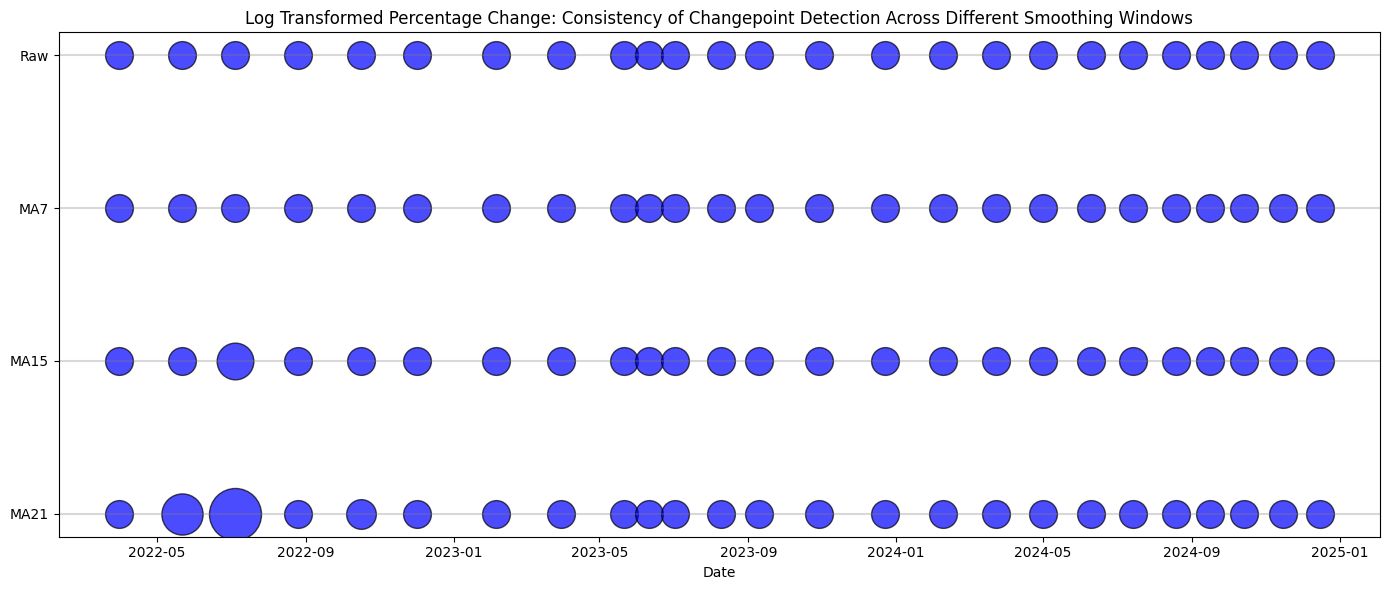

In [54]:
# Create a heatmap visualization of consistent changepoints
plt.figure(figsize=(14, 6))
y_positions = {'Raw': 3, 'MA7': 2, 'MA15': 1, 'MA21': 0}
y_labels = list(y_positions.keys())

# Plot horizontal lines for each method
for method, y_pos in y_positions.items():
    plt.axhline(y=y_pos, color='gray', linestyle='-', alpha=0.3)

# Plot circles for each detection
for date, methods in consistent_changepoints.items():
    for method, magnitude in methods:
        size = max(20, min(500, magnitude * 100))
        plt.scatter(date, y_positions[method], s = size ** 2,
                   alpha=0.7, color='blue', edgecolor='black')

# # Add event markers
# for event_name, event_date in key_events.items():
#     plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.5)
#     plt.text(event_date, 3.5, event_name, rotation=90, 
#             verticalalignment='bottom', horizontalalignment='right')

plt.yticks(list(y_positions.values()), y_labels)
plt.xlabel('Date')
plt.title('Log Transformed Percentage Change: Consistency of Changepoint Detection Across Different Smoothing Windows')
plt.tight_layout()
plt.show()

In [57]:
consistent_changepoints

{Timestamp('2022-07-04 10:51:31'): [('Raw', 0.00561893),
  ('MA7', 0.0375529),
  ('MA15', 0.264411),
  ('MA21', 0.374515)],
 Timestamp('2022-08-25 06:17:38'): [('Raw', 0.00547577),
  ('MA7', 0.0329134),
  ('MA15', 0.137145),
  ('MA21', 0.190515)],
 Timestamp('2022-10-16 04:46:36'): [('Raw', 0.00515487),
  ('MA7', 0.0402634),
  ('MA15', 0.175512),
  ('MA21', 0.213709)],
 Timestamp('2022-05-21 21:10:11'): [('Raw', 0.00428256),
  ('MA7', 0.0232446),
  ('MA15', 0.188128),
  ('MA21', 0.296622)],
 Timestamp('2022-12-01 16:53:28'): [('Raw', 0.00346843),
  ('MA7', 0.0358117),
  ('MA15', 0.120259),
  ('MA21', 0.121191)],
 Timestamp('2022-03-30 15:27:21'): [('Raw', 0.00255653),
  ('MA7', 7.43634e-07),
  ('MA15', 0.000232555),
  ('MA21', 0.00868144)],
 Timestamp('2023-02-04 20:11:00'): [('Raw', 0.00176569),
  ('MA7', 0.0240006),
  ('MA15', 6.53568e-05),
  ('MA21', 3.72966e-05)],
 Timestamp('2023-03-30 02:43:01'): [('Raw', 1.87203e-05),
  ('MA7', 0.00595796),
  ('MA15', -4.72128e-08),
  ('MA21', 2